### **Load Libraries**

In [ ]:
#  Imports
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import numpy as np
import pandas as pd
import os
import time
import json


### **Dataset**

In [ ]:
# Define paths
train_dir = "/content/drive/MyDrive/chest_xray/train"
test_dir = "/content/drive/MyDrive/chest_xray/test"

labels = ['NORMAL','PNEUMONIA']
img_size = 224

def get_data(data_dir):
    data = []
    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_path = os.path.join(path, img)
                data.append([img_path, label])
            except Exception as e:
                print(e)
    return pd.DataFrame(data, columns=['filepath', 'label'])

# Load data
train = get_data(train_dir)
test = get_data(test_dir)

print(test.head(5))
print(f"\nThe shape of The Train data is: {train.shape}")
print(f"The shape of The Test data is: {test.shape}")

                                            filepath      label
0  /content/drive/MyDrive/chest_xray/test/PNEUMON...  PNEUMONIA
1  /content/drive/MyDrive/chest_xray/test/PNEUMON...  PNEUMONIA
2  /content/drive/MyDrive/chest_xray/test/PNEUMON...  PNEUMONIA
3  /content/drive/MyDrive/chest_xray/test/PNEUMON...  PNEUMONIA
4  /content/drive/MyDrive/chest_xray/test/PNEUMON...  PNEUMONIA

The shape of The Train data is: (5233, 2)
The shape of The Test data is: (625, 2)


In [ ]:

# Check class imbalance
def check_class_imbalance(directory):
    """Check class distribution in the dataset"""
    print(f"Checking class distribution in: {directory}")
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            count = len([f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
            print(f"  {class_name}: {count} images")
    print()

print("Mendeley Dataset Class Distribution:")
check_class_imbalance(train_dir)
check_class_imbalance(test_dir)

Mendeley Dataset Class Distribution:
Checking class distribution in: /content/drive/MyDrive/chest_xray/train
  NORMAL: 1349 images
  PNEUMONIA: 3883 images

Checking class distribution in: /content/drive/MyDrive/chest_xray/test
  PNEUMONIA: 390 images
  NORMAL: 234 images



In [ ]:

# Split into train, val, test (validation split from training directory)
BATCH_SIZE = 32
IMG_SIZE = (224, 224)

# Data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    validation_split=0.1  # 10% validation split
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training',
    shuffle=True
)

val_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation',
    shuffle=False
)

test_gen = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

Found 4710 images belonging to 2 classes.
Found 522 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [ ]:
# Calculate class weights
labels_array = train_gen.classes
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels_array),
    y=labels_array
)
class_weights = dict(enumerate(class_weights))

In [ ]:
# Load and freeze DenseNet-121
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in base_model.layers:
    layer.trainable = False

# Build model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)
model = Model(inputs=base_model.input, outputs=x)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_2    │ (None, 230, 230,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d_2… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_3    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_3… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 7,300,161 (27.85 MB)

 Trainable params: 262,657 (1.00 MB)

 Non-trainable params: 7,037,504 (26.85 MB)

In [ ]:
# Compile and train
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

BASE_PATH = "/content/drive/MyDrive/chest_xray"
best_model_path = os.path.join(BASE_PATH, 'DenseNet_121_Best.h5')
model_checkpoint = ModelCheckpoint(
    filepath=best_model_path,
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

start_time = time.time()

history = model.fit(
    train_gen,
    epochs=30,
    validation_data=val_gen,
    verbose=1,
    callbacks=[early_stopping, model_checkpoint],
    class_weight=class_weights
)

end_time = time.time()
training_time = (end_time - start_time) / 60
print(f"Training took {training_time:.2f} minutes")

# Save the training history to a JSON file so you can reload it later
history_path = os.path.join(BASE_PATH, 'DenseNet_121_history.json')
with open(history_path, 'w') as f:
    json.dump(history.history, f)

print(f"Training history saved to: {history_path}")

Epoch 1/30
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 18s/step - accuracy: 0.8272 - loss: 0.3824 
Epoch 1: val_loss improved from inf to 0.13652, saving model to /content/drive/MyDrive/chest_xray/DenseNet_121_Best.h5


148/148 ━━━━━━━━━━━━━━━━━━━━ 2982s 20s/step - accuracy: 0.8275 - loss: 0.3818 - val_accuracy: 0.9425 - val_loss: 0.1365
Epoch 2/30
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9031 - loss: 0.2262
Epoch 2: val_loss improved from 0.13652 to 0.13248, saving model to /content/drive/MyDrive/chest_xray/DenseNet_121_Best.h5


148/148 ━━━━━━━━━━━━━━━━━━━━ 239s 2s/step - accuracy: 0.9032 - loss: 0.2261 - val_accuracy: 0.9464 - val_loss: 0.1325
Epoch 3/30
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9249 - loss: 0.1851
Epoch 3: val_loss did not improve from 0.13248
148/148 ━━━━━━━━━━━━━━━━━━━━ 254s 2s/step - accuracy: 0.9249 - loss: 0.1851 - val_accuracy: 0.9368 - val_loss: 0.1440
Epoch 4/30
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9248 - loss: 0.1910
Epoch 4: val_loss did not improve from 0.13248
148/148 ━━━━━━━━━━━━━━━━━━━━ 262s 2s/step - accuracy: 0.9249 - loss: 0.1909 - val_accuracy: 0.9425 - val_loss: 0.1507
Epoch 5/30
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9375 - loss: 0.1539
Epoch 5: val_loss improved from 0.13248 to 0.13034, saving model to /content/drive/MyDrive/chest_xray/DenseNet_121_Best.h5


148/148 ━━━━━━━━━━━━━━━━━━━━ 263s 2s/step - accuracy: 0.9375 - loss: 0.1539 - val_accuracy: 0.9464 - val_loss: 0.1303
Epoch 6/30
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9445 - loss: 0.1478
Epoch 6: val_loss did not improve from 0.13034
148/148 ━━━━━━━━━━━━━━━━━━━━ 255s 2s/step - accuracy: 0.9445 - loss: 0.1478 - val_accuracy: 0.9387 - val_loss: 0.1314
Epoch 7/30
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9411 - loss: 0.1390
Epoch 7: val_loss improved from 0.13034 to 0.11514, saving model to /content/drive/MyDrive/chest_xray/DenseNet_121_Best.h5


148/148 ━━━━━━━━━━━━━━━━━━━━ 265s 2s/step - accuracy: 0.9411 - loss: 0.1391 - val_accuracy: 0.9598 - val_loss: 0.1151
Epoch 8/30
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9458 - loss: 0.1337
Epoch 8: val_loss did not improve from 0.11514
148/148 ━━━━━━━━━━━━━━━━━━━━ 231s 2s/step - accuracy: 0.9457 - loss: 0.1338 - val_accuracy: 0.9521 - val_loss: 0.1270
Epoch 9/30
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9437 - loss: 0.1507
Epoch 9: val_loss did not improve from 0.11514
148/148 ━━━━━━━━━━━━━━━━━━━━ 233s 2s/step - accuracy: 0.9436 - loss: 0.1507 - val_accuracy: 0.9502 - val_loss: 0.1223
Epoch 10/30
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9389 - loss: 0.1391
Epoch 10: val_loss did not improve from 0.11514
148/148 ━━━━━━━━━━━━━━━━━━━━ 233s 2s/step - accuracy: 0.9389 - loss: 0.1391 - val_accuracy: 0.9387 - val_loss: 0.1469
Epoch 11/30
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9403 - loss: 0.1425
Epoch 11: val_loss did not improve from 0.11

148/148 ━━━━━━━━━━━━━━━━━━━━ 235s 2s/step - accuracy: 0.9484 - loss: 0.1287 - val_accuracy: 0.9617 - val_loss: 0.1025
Epoch 13/30
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9437 - loss: 0.1350
Epoch 13: val_loss did not improve from 0.10252
148/148 ━━━━━━━━━━━━━━━━━━━━ 224s 2s/step - accuracy: 0.9437 - loss: 0.1350 - val_accuracy: 0.9253 - val_loss: 0.2078
Epoch 14/30
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9433 - loss: 0.1571
Epoch 14: val_loss did not improve from 0.10252
148/148 ━━━━━━━━━━━━━━━━━━━━ 235s 2s/step - accuracy: 0.9433 - loss: 0.1570 - val_accuracy: 0.9444 - val_loss: 0.1302
Epoch 15/30
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9475 - loss: 0.1417
Epoch 15: val_loss improved from 0.10252 to 0.09547, saving model to /content/drive/MyDrive/chest_xray/DenseNet_121_Best.h5


148/148 ━━━━━━━━━━━━━━━━━━━━ 236s 2s/step - accuracy: 0.9475 - loss: 0.1416 - val_accuracy: 0.9636 - val_loss: 0.0955
Epoch 16/30
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9506 - loss: 0.1277
Epoch 16: val_loss did not improve from 0.09547
148/148 ━━━━━━━━━━━━━━━━━━━━ 227s 2s/step - accuracy: 0.9505 - loss: 0.1277 - val_accuracy: 0.9138 - val_loss: 0.2022
Epoch 17/30
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9494 - loss: 0.1359
Epoch 17: val_loss did not improve from 0.09547
148/148 ━━━━━━━━━━━━━━━━━━━━ 226s 2s/step - accuracy: 0.9495 - loss: 0.1358 - val_accuracy: 0.9502 - val_loss: 0.1228
Epoch 18/30
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9475 - loss: 0.1388
Epoch 18: val_loss did not improve from 0.09547
148/148 ━━━━━━━━━━━━━━━━━━━━ 226s 2s/step - accuracy: 0.9475 - loss: 0.1387 - val_accuracy: 0.9598 - val_loss: 0.1003
Epoch 19/30
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9565 - loss: 0.1260
Epoch 19: val_loss did not improve from 

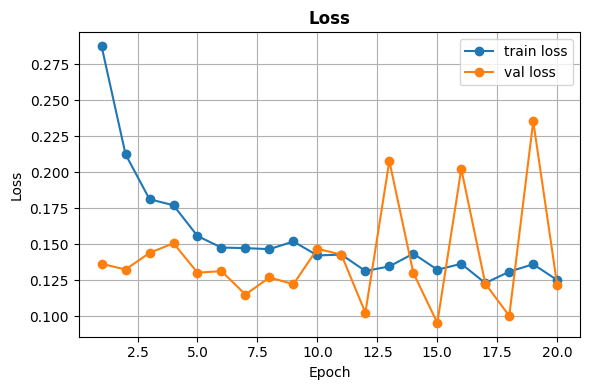

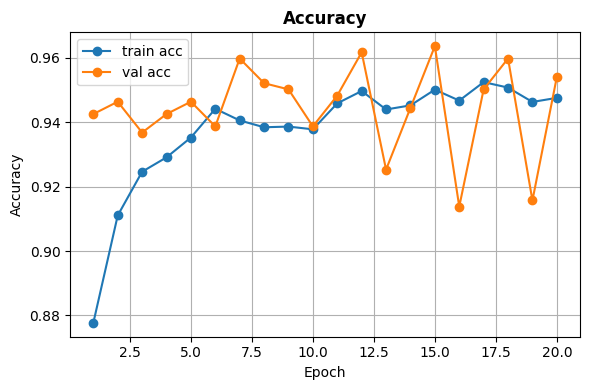

In [ ]:
import matplotlib.pyplot as plt

# Extract history values
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(train_loss) + 1)

# Plot Loss Curve
plt.figure(figsize=(6, 4))
plt.plot(epochs, train_loss, marker='o', label='train loss')
plt.plot(epochs, val_loss, marker='o', label='val loss')
plt.title('Loss', fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot Accuracy Curve
plt.figure(figsize=(6, 4))
plt.plot(epochs, train_acc, marker='o', label='train acc')
plt.plot(epochs, val_acc, marker='o', label='val acc')
plt.title('Accuracy', fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### **Evaluation**

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Loaded best model from: /content/drive/MyDrive/chest_xray/DenseNet_121_Best.h5
Size of best model (on disk): 31.12 MB
20/20 ━━━━━━━━━━━━━━━━━━━━ 318s 16s/step - accuracy: 0.8604 - loss: 0.3159
20/20 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step

Baseline DenseNet121 Results:
Test Loss: 0.2012
Accuracy: 0.9151
Precision: 0.9002
Recall: 0.9718
F1-score: 0.9346
AUROC: 0.9789


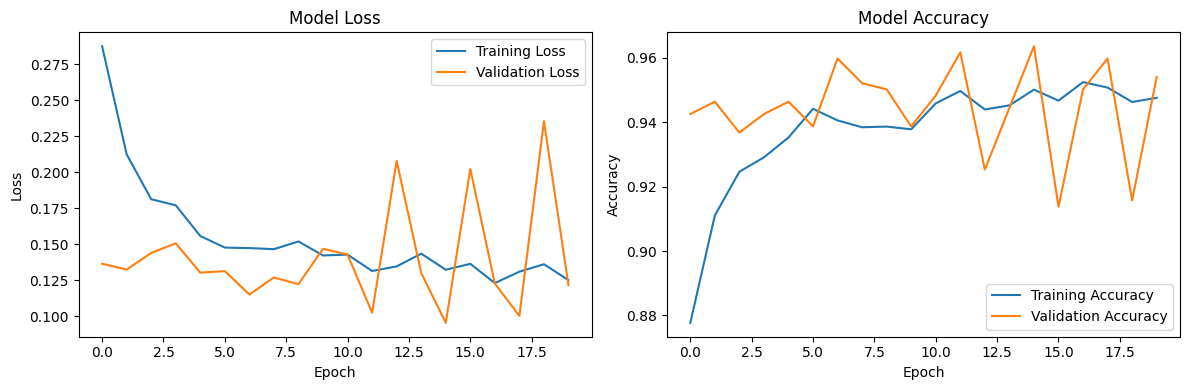

In [ ]:
# Load the best‐saved DenseNet-121 model before evaluation
import os
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix
)

BASE_PATH = "/content/drive/MyDrive/chest_xray"
best_model_path = os.path.join(BASE_PATH, 'DenseNet_121_Best.h5')

model = tf.keras.models.load_model(best_model_path)

# Check size of the loaded model file
best_size_mb = os.path.getsize(best_model_path) / (1024 ** 2)
print(f"Loaded best model from: {best_model_path}")
print(f"Size of best model (on disk): {best_size_mb:.2f} MB")


# Evaluate on the test set using the best weights
test_loss, test_acc = model.evaluate(test_gen, verbose=1)
y_pred = model.predict(test_gen, verbose=1)
y_true = test_gen.labels

# Binarise predictions with threshold 0.50
y_pred_binary = (y_pred > 0.50).astype(int)

# Calculate classification metrics
accuracy = accuracy_score(y_true, y_pred_binary)
precision_val = precision_score(y_true, y_pred_binary)
recall_val = recall_score(y_true, y_pred_binary)
f1 = f1_score(y_true, y_pred_binary)
auroc = roc_auc_score(y_true, y_pred)

# Save results to CSV
results = {
    'Model': 'DenseNet121',
    'Test Loss': test_loss,
    'Accuracy': accuracy,
    'Precision': precision_val,
    'Recall': recall_val,
    'F1-score': f1,
    'AUROC': auroc,
}
pd.DataFrame([results]).to_csv(
    os.path.join(BASE_PATH, 'Densenet121_baseline_results_Mendeley.csv'),
    index=False
)

print("\nBaseline DenseNet121 Results:")
print(f"Test Loss: {test_loss:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision_val:.4f}")
print(f"Recall: {recall_val:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"AUROC: {auroc:.4f}")

# Load the saved training history from JSON for plotting
history_path = os.path.join(BASE_PATH, 'DenseNet_121_history.json')
with open(history_path, 'r') as f:
    history_dict = json.load(f)

# Plot training history for loss and accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_dict['loss'], label='Training Loss')
plt.plot(history_dict['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_dict['accuracy'], label='Training Accuracy')
plt.plot(history_dict['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

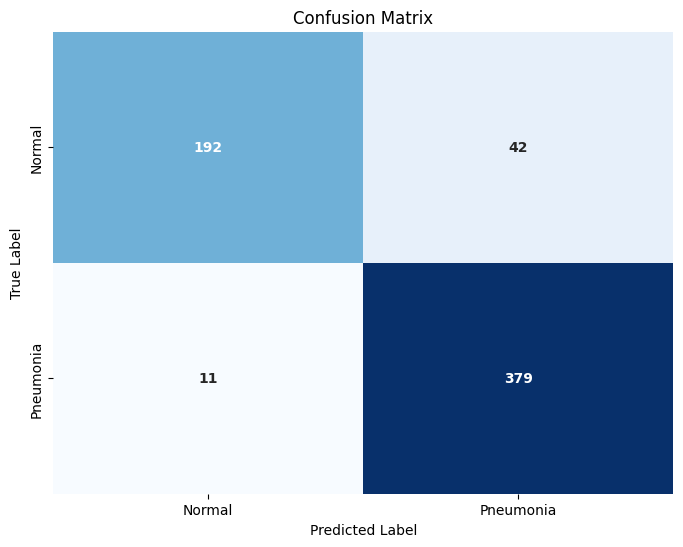

In [ ]:
# Compute and visualise the confusion matrix
cm = confusion_matrix(y_true, y_pred_binary)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, annot_kws={'fontweight': 'bold'})
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.xticks(ticks=[0.5, 1.5], labels=["Normal", "Pneumonia"])
plt.yticks(ticks=[0.5, 1.5], labels=["Normal", "Pneumonia"])
plt.show()


Classification Report:

              precision    recall  f1-score   support

      NORMAL     0.9458    0.8205    0.8787       234
   PNEUMONIA     0.9002    0.9718    0.9346       390

    accuracy                         0.9151       624
   macro avg     0.9230    0.8962    0.9067       624
weighted avg     0.9173    0.9151    0.9137       624



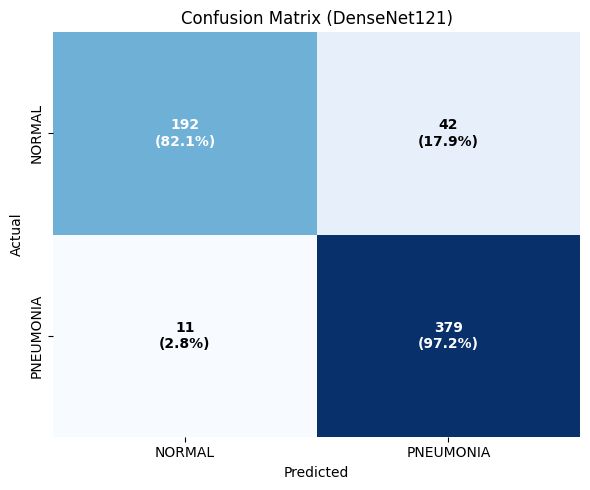

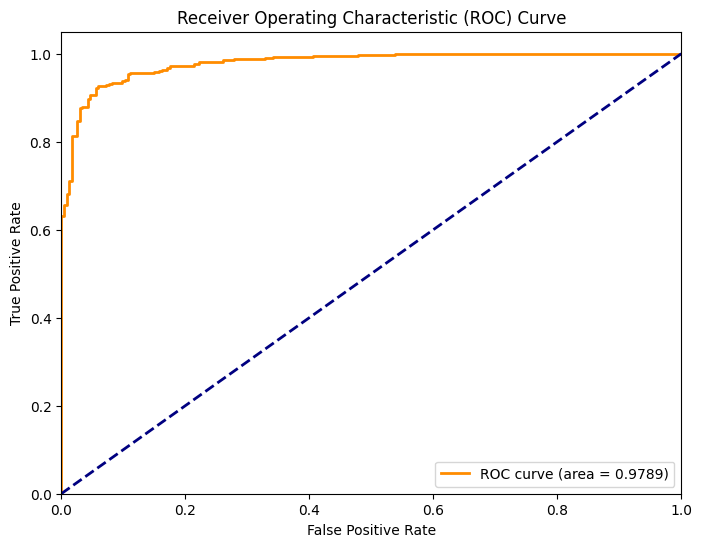

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc

# Print the classification report
target_names = list(test_gen.class_indices.keys())
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred_binary, target_names=target_names, digits=4))

# Compute confusion matrix (counts + row-wise %)
cm = confusion_matrix(y_true, y_pred_binary)
cm_percent = (cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]) * 100

plt.figure(figsize=(6, 5))
ax = sns.heatmap(
    cm,
    annot=False,
    fmt='d',
    cmap='Blues', cbar=False,
    xticklabels=target_names,
    yticklabels=target_names
)

# Annotate each cell with “count\n(percentage%)”
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        count = cm[i, j]
        pct   = cm_percent[i, j]
        ax.text(
            j + 0.5,
            i + 0.5,
            f"{count}\n({pct:.1f}%)",
            ha='center',
            va='center',
            color='white' if i == j else 'black',
            fontweight='bold'
        )

plt.title("Confusion Matrix (DenseNet121)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# ROAUC Curve

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()